In [ ]:
# 코랩에서 사용할 경우 사용
from google.colab import drive
drive.mount('/content/drive')



In [ ]:
# 코랩에서 사용할 경우 사용
import os
# 저장된 파일의 위치를 지정
os.chdir('/content/drive/MyDrive/Colab Notebooks/vocab") 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

import pandas as pd
import numpy as np
import sentencepiece as spm
from gensim.models import Word2Vec

plt.rc('font', family='NanumGothic') # For Windows

In [2]:
train = pd.read_csv("train_data.txt", sep='?', encoding='euc-kr') 
test = pd.read_csv("test_data.txt", sep='?', encoding='euc-kr') 

# 라벨링 및 데이터 병합
type_dict = {0 :'기타(쓰레기 화재 등)', 1:'건축, 구조물 화재',2:'자동차, 철도차량 화재',3:'임야 화재',4: '선박, 항공기 화재' ,5:'위험물, 가스제조소 등의 화재'}
df = pd.concat([train, test], axis=0)
labels = df['화재유형'].values

 ### 라벨 분포확인

In [3]:
name = []
ylim = []
for i in range(6):
    name.append(type_dict[i])
    ylim.append(list(labels).count(i))
    print(type_dict[i],':',list(labels).count(i)) 
 

기타(쓰레기 화재 등) : 2800
건축, 구조물 화재 : 7462
자동차, 철도차량 화재 : 1779
임야 화재 : 1986
선박, 항공기 화재 : 36
위험물, 가스제조소 등의 화재 : 14


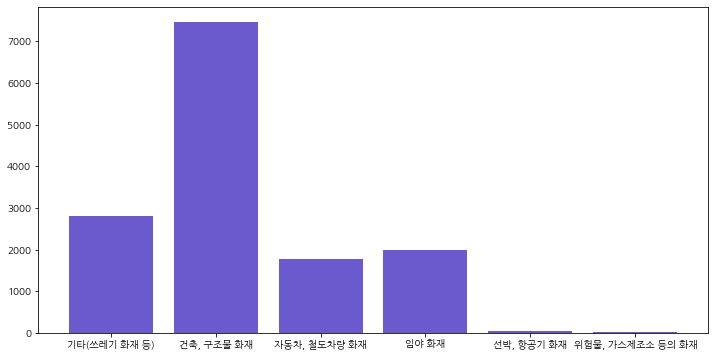

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(name, ylim, color = 'slateblue')

#plt.savefig('label.png', dpi = 200)
plt.show()


### 데이터 전처리

In [5]:
# 특수문자, 남 52세 등의 문자를 제거
df['발화개요'] = df['발화개요'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』○\\‘|\(\)\[\]\<\>`\'…》\\n\t;]+', " ", regex=True)
df['발화개요'] = df['발화개요'].str.replace(r'[남,여][0-9]{1,2}세','',regex=True)
df['발화개요'] = df['발화개요'].str.replace(r'[남,여][0-9]{1,2}년생','',regex=True)
df['발화개요'] = df['발화개요'].str.replace(r'[남,여] [0-9]{1,2}세','',regex=True)
df['발화개요'] = df['발화개요'].str.replace(r'[남,여] [0-9]{1,2}년생','',regex=True)
df['발화개요'] = df['발화개요'].str.replace('  ','',regex=True)
df['발화개요'] = df['발화개요'].str.strip() 

In [6]:
# 발화의 길이가 18 미만인 데이터를 제거
drop_index = df[df['발화개요'].str.len() < 18].index
df = df.drop(drop_index)

# 인덱스리셋 후 null값 제거
df = df.reset_index().iloc[:,1:]
df = df.dropna()
labels = df['화재유형'].values

# 1row == 1str
sentences = [str(sentence) for sentence in df['발화개요']] 

['최초 신고자 쓰레기차 기사 서용석에 의하면 쓰레기를 비우려 매립장 진입 시 매립장 오른쪽 부분에서 불길이 보여 119에 신고하였다 하며 현장조사한 바 쓰레기매립장에 매립된 야외 쓰레기가 소실된 화재로 평소 소각한 쓰레기와 일반 쓰레기를 함께 매립하던 상항과 기타 다른 화원이 발견되지 않은 점으로 보아 소각한 쓰레기에 남아있던 불씨의 열이 장시간 축적되어 훈소되면서 쓰레기에 착화되어 주변 쓰레기로 연소 확대 된 화재로 추정됨',  
 '운행 중이던 덤프 트럭 타이어가 파열되면서 발생한 마찰 스파크에 의해 타이어 부분에서 발화되어 조수석 캡 부분으로 연소 확대된 화재로 추정됨',  
 '최초목격자송기연이차를 타고 주변을 지나던 중 유니온사료 창고에서 흰 연기가 발생하여 공장 관계자에게 알리고 119에 신고함선착대현장도착 당시창고내에 적재된어분에서국소적으로연기및불길이발생하는 상황으로 화재를 진압함현장조사한바발화지점은 어분이 적재된 부분으로 다른 발화열원이 식별되지 아니하며 어분이 발효열로 인해 발화한 화재로 추정함',  
 '자동화재속보설비로 신고 된 사건으로선착대 도착한바 현관 등 시건장치 잠겨 있어 잠금 해제 후 진입한바 3층 사무실에서 스프링클러가 작동하여 책상 위 컴퓨터 등의 화재가 진화된 상황으로 인명대피 등의 상황은 없었으며현장조사한바 책상 위 컴퓨터 모니터와 파티션 사이의 공간에서 발화하여 진화된 화재로 발화지점 중앙부의 멀티콘센트에서 주변부로 연소확대된 패턴이 확인되며 방화가스 등 다른 화인이 없는 점으로 보아 전기적 요인에 의한 화재로 추정됨',  
 ...]

### 데이터 토큰화

In [7]:
# sentencepiece 학습
# sentencepiece는 학습데이터를 txt 형식으로 받음
with open('imdb.txt','w',encoding = 'utf-8') as f:
    f.write('\n'.join(sentences))

# --input=학습데이터.txt, --model_prefix=저장파일명, --vocab_size = 분리할 단어 수 ,--model_type=사용할모델(bpe)
spm.SentencePieceTrainer.Train('--input=imdb.txt --model_prefix=imdb --vocab_size=10000 --model_type=bpe --max_sentence_length=9999') 
vocab_list = pd.read_csv('imdb.vocab', sep = '\t', header = None, quoting = csv.QUOTE_NONE) # 단어사전, vocab = 10000

In [8]:
# 학습모델 로딩
sp = spm.SentencePieceProcessor()
vocab_file = 'imdb.model'
sp.load(vocab_file)

# 문장을 sentencepiece로 토큰화 
sentences_index = [ sp.encode_as_pieces(i) for i in sentences] # 13936

In [10]:
 for i in sp.encode_as_pieces(sentences[0]):
        print(i, end = ' ')

▁최초 ▁신고자 ▁쓰레기 차 ▁기사 ▁서용 석에 ▁의하면 ▁쓰레기를 ▁비 우 려 ▁매립 장 ▁진입 ▁시 ▁매립 장 ▁오른쪽 ▁부분에서 ▁불길이 ▁보여 ▁119 에 ▁신고하였다 ▁하며 ▁현장조사한 ▁바 ▁쓰레기 매 립 장에 ▁매립 된 ▁야외 ▁쓰레기가 ▁소실된 ▁화재로 ▁평소 ▁소각한 ▁쓰레기와 ▁일반 ▁쓰레기를 ▁함께 ▁매립 하던 ▁상 항 과 ▁기타 ▁다른 ▁화원이 ▁발견되지 ▁않은 ▁점으로 ▁보아 ▁소각한 ▁쓰레기에 ▁남아있던 ▁불씨 의 ▁열이 ▁장시간 ▁축적되어 ▁훈소 되면서 ▁쓰레기에 ▁착화되어 ▁주변 ▁쓰레기 로 ▁연소 ▁확대 ▁된 ▁화재로 ▁추정됨 

### 토큰화 후 특수문자 및 불용어 제거

In [11]:
# 불용어
stop_word = pd.read_csv('불용어.txt', sep='\n', header=None) # 사전에 지정한 단어를 삭제
stop_word = stop_word[0].tolist()

In [12]:
# _ 문자와 len = 1인 단어, 불용어 제거
import re

p = re.compile('[^0-9]+')# 숫자단어를 제거

sentences_index_pre = []
for sentence in sentences_index:
    # sentencepiece토큰화 결과물을 '▁최초'->'최초'로 변경 및 한글자인 단어를 제거
    tmp_sent = [i.replace('▁','') for i in sentence if len(i) > 2]

    # 사전에 지정한 불용어 및 숫자를 제거
    tmp_sent = [word for z in tmp_sent for word in p.findall(z) if word not in stop_word  ]
    sentences_index_pre.append(tmp_sent) 

### DIctionary정리

In [14]:
sentences_dict ={}
# 유형별 사용한 단어를 추출
for i in range(len(sentences_index_pre)):

    try: 
        sentences_dict[labels[i]] += sentences_index_pre[i]
    except:
        sentences_dict[labels[i]] = sentences_index_pre[i]

{0: ['최초',
  '쓰레기',
  '기사',
  '서용',
  '쓰레기를',
  '매립',
  '진입',
  '매립',
  '오른쪽',
  '부분에서',
  '불길이',
  '보여',
  '하며',},  
  1: ['최초',
  '쓰레기',
  '기사',
  '서용',
  '쓰레기를',
  '매립',
  '진입',
  '매립',
  '오른쪽',
  '부분에서',
  '불길이',
  '보여',
  '하며',},  ....}
  

# 유형별 문장으로 정리
sentences_index_dict = {0 :[],1:[],2:[],3:[],4:[],5:[]}
i = 0
sentences_index = []
for sentence in sentences_index:
    tmp_sent = [i.replace('▁','') for i in sentence if len(i) > 2]
    
    tmp_sent = [word for z in tmp_sent for word in p.findall(z) if word not in stop_word  ]
    try : 
        sentences_index_dict[labels[i]] += [tmp_sent]
    except : 
        sentences_index_dict[labels[i]] = [tmp_sent]
    i += 1 

 {0: [문장1], [문장2],....},  
1: [문장1], [문장2],.....}

In [15]:
# 각 토픽별 개별학습
#word2vec_model = {0:[],1:[],2:[],3:[],4:[],5:[]}
#for i in range(6):
#    word2vec_model[i] = Word2Vec(sentences = sentences_index_dict[i], size = 100, window = 5, min_count = 5, workers = 4 ,sg = 0)

# 전체 문장 학습
word2vec_model= Word2Vec(sentences = sentences_index_pre, size = 100, window = 5, min_count = 5, workers = 4 ,sg = 0)

###  Count

In [16]:
from collections import Counter
import operator
word_count_dict = {}

for i in range(6):
    word_count_dict[type_dict[i]] = Counter(sentences_dict[i])

In [17]:
for i in type_dict.values():
    print('{} : '.format(i),sorted(word_count_dict[i].items(),key = operator.itemgetter(1), reverse= True)[:20]) 
    print()

기타(쓰레기 화재 등) :  [('쓰레기', 1149), ('연소', 1137), ('소각', 1096), ('연기가', 766), ('발화된', 721), ('화재임', 713), ('쓰레기를', 650), ('주변', 650), ('최초', 583), ('화재가', 579), ('흔적이', 559), ('보여', 489), ('연소확대', 482), ('인근', 458), ('불이', 453), ('불길이', 451), ('불티가', 447), ('화염이', 447), ('화재', 441), ('담배꽁초가', 431)]

건축, 구조물 화재 :  [('연소', 3324), ('연기가', 3288), ('주택', 2805), ('최초', 2353), ('발화된', 2196), ('화염이', 1851), ('내부', 1766), ('화재임', 1721), ('상태로', 1706), ('있던', 1649), ('화재', 1634), ('화재가', 1630), ('건물', 1558), ('보니', 1547), ('소유자', 1513), ('보여', 1509), ('진술에', 1504), ('불길이', 1397), ('비닐하우스', 1355), ('발생하여', 1335)]

자동차, 철도차량 화재 :  [('차량', 2730), ('운전자', 1008), ('엔진룸', 924), ('연기가', 881), ('운행', 687), ('연소', 577), ('발화된', 566), ('엔진', 542), ('엔진룸에서', 534), ('화염이', 517), ('최초', 468), ('발생하여', 453), ('화재가', 448), ('운전석', 430), ('상태로', 423), ('차량을', 423), ('차량이', 385), ('보여', 379), ('갓길에', 378), ('차량의', 331)]

임야 화재 :  [('소각', 1473), ('연소', 1384), ('쓰레기', 935), ('흔적이', 693), ('연소확대', 681), ('화재임', 619), (

### 각 토픽별 고유단어를 추출

In [18]:
# 각 주제가 가진 고유단어 추출
zero_word = {type_dict[0]:[],type_dict[1]:[],type_dict[2]:[],type_dict[3]:[],type_dict[4]:[],type_dict[5]:[]}
for topic_num in range(6):
    tmp_list = []
    topic_word = sorted(word_count_dict[type_dict[topic_num]].items(),key = operator.itemgetter(1),
                        reverse= True)
    for i in range(6):
        if i != topic_num:
            for j in topic_word:
                if word_count_dict[type_dict[i]][j[0]] == 0:
                    tmp_list.append(j[0])
    for word in set(tmp_list):
        if tmp_list.count(word) == 5:
            zero_word[type_dict[topic_num]] += [word]

In [20]:
a = []
for i in sorted(word_count_dict[type_dict[0]].items(),key = operator.itemgetter(1), reverse= True):
    tmp_list=[]
    for j in range(1,6):
        if word_count_dict[type_dict[j]][i[0]] == 0:
            tmp_list.append(i[0])
    for word in set(tmp_list):
        if tmp_list.count(word) == 4:
            a.append(word)

### 각 토픽별 정규화를 통해 대표단어를 추출 

In [22]:
topic_vocab = list(type_dict.values())
word_vocab = sorted(list(set([word for words in word_count_dict.values() for word in words.keys()])))
topic_len = len(topic_vocab)
word_len = len(word_vocab)

In [23]:
word_mat = np.zeros((word_len, topic_len))
for i in range(topic_len):
    for j in range(word_len):
        try:
            word_mat[j, i] = word_count_dict[topic_vocab[i]][word_vocab[j]]        
        except:
            word_mat[j, i] = 0

In [24]:
# word_mat 데이터프레임
df2 = pd.DataFrame(word_mat)
df2.index = word_vocab
df2.columns = topic_vocab

In [26]:
df3 = pd.DataFrame()
for i in range(6):
    total = df2.sum(axis = 1)
    df3[i] = df2.iloc[:,i]/total


In [28]:
concat_df = df3[df3[1] > 0.9]
concat_df['label'] = 1
for i in range(0,6):
    if i != 1:
        tmp_df = df3[df3[i] > 0.8]
        tmp_df['label'] = i
        concat_df = pd.concat([concat_df, tmp_df])

C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### 시각화 

In [30]:
from sklearn.datasets import load_digits
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline

# 그래프색을 임의로 생성
#colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#             for i in range(6)]
colors =['red', 'pink', 'green', 'gray', 'blue','black']

tsne = TSNE(random_state=0)

digits_tsne = tsne.fit_transform(concat_df.iloc[:,:6])# word_mat을 2차원으로 축소

C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


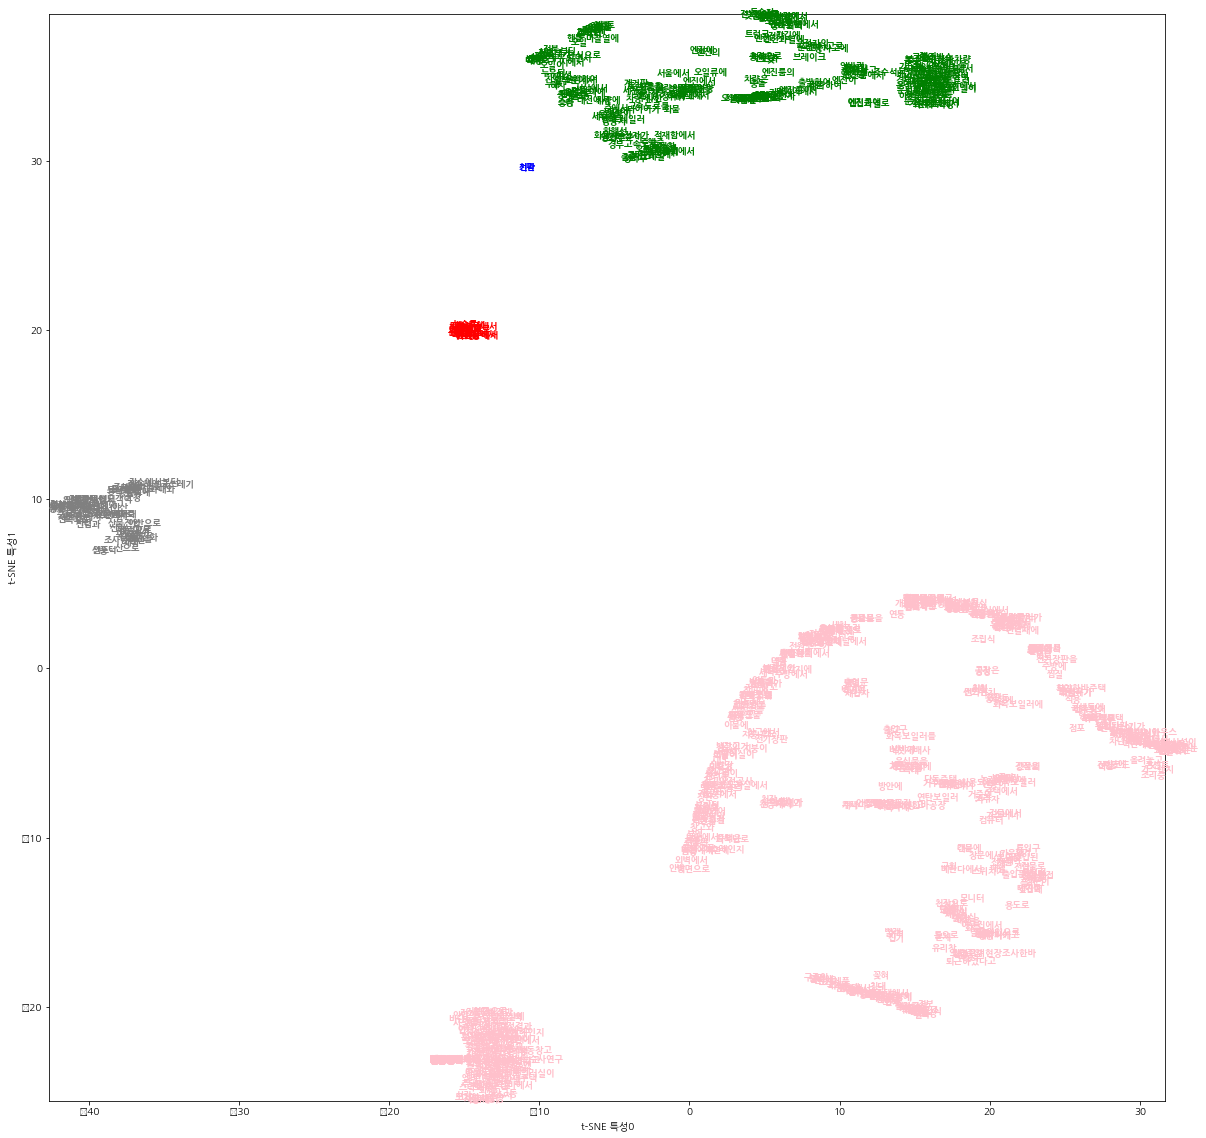

In [31]:
# 텍스트를 통해 위치를 표시
plt.rcParams["figure.figsize"] = (20,20)
for i in range(len(digits_tsne)):
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], concat_df.index[i], # x, y , 그룹
                                                                       
             color=colors[concat_df['label'][i]], # 색상
            
             fontdict={'weight': 'bold', 'size':9}) # font

    
        
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max()) # 최소, 최대

plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max()) # 최소, 최대

plt.xlabel('t-SNE 특성0') # x축 이름

plt.ylabel('t-SNE 특성1') # y축 이름

plt.savefig('fig1.png', dpi=400)
#plt.show() # 그래프 출력

C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Admin\.conda\envs\pytoch\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


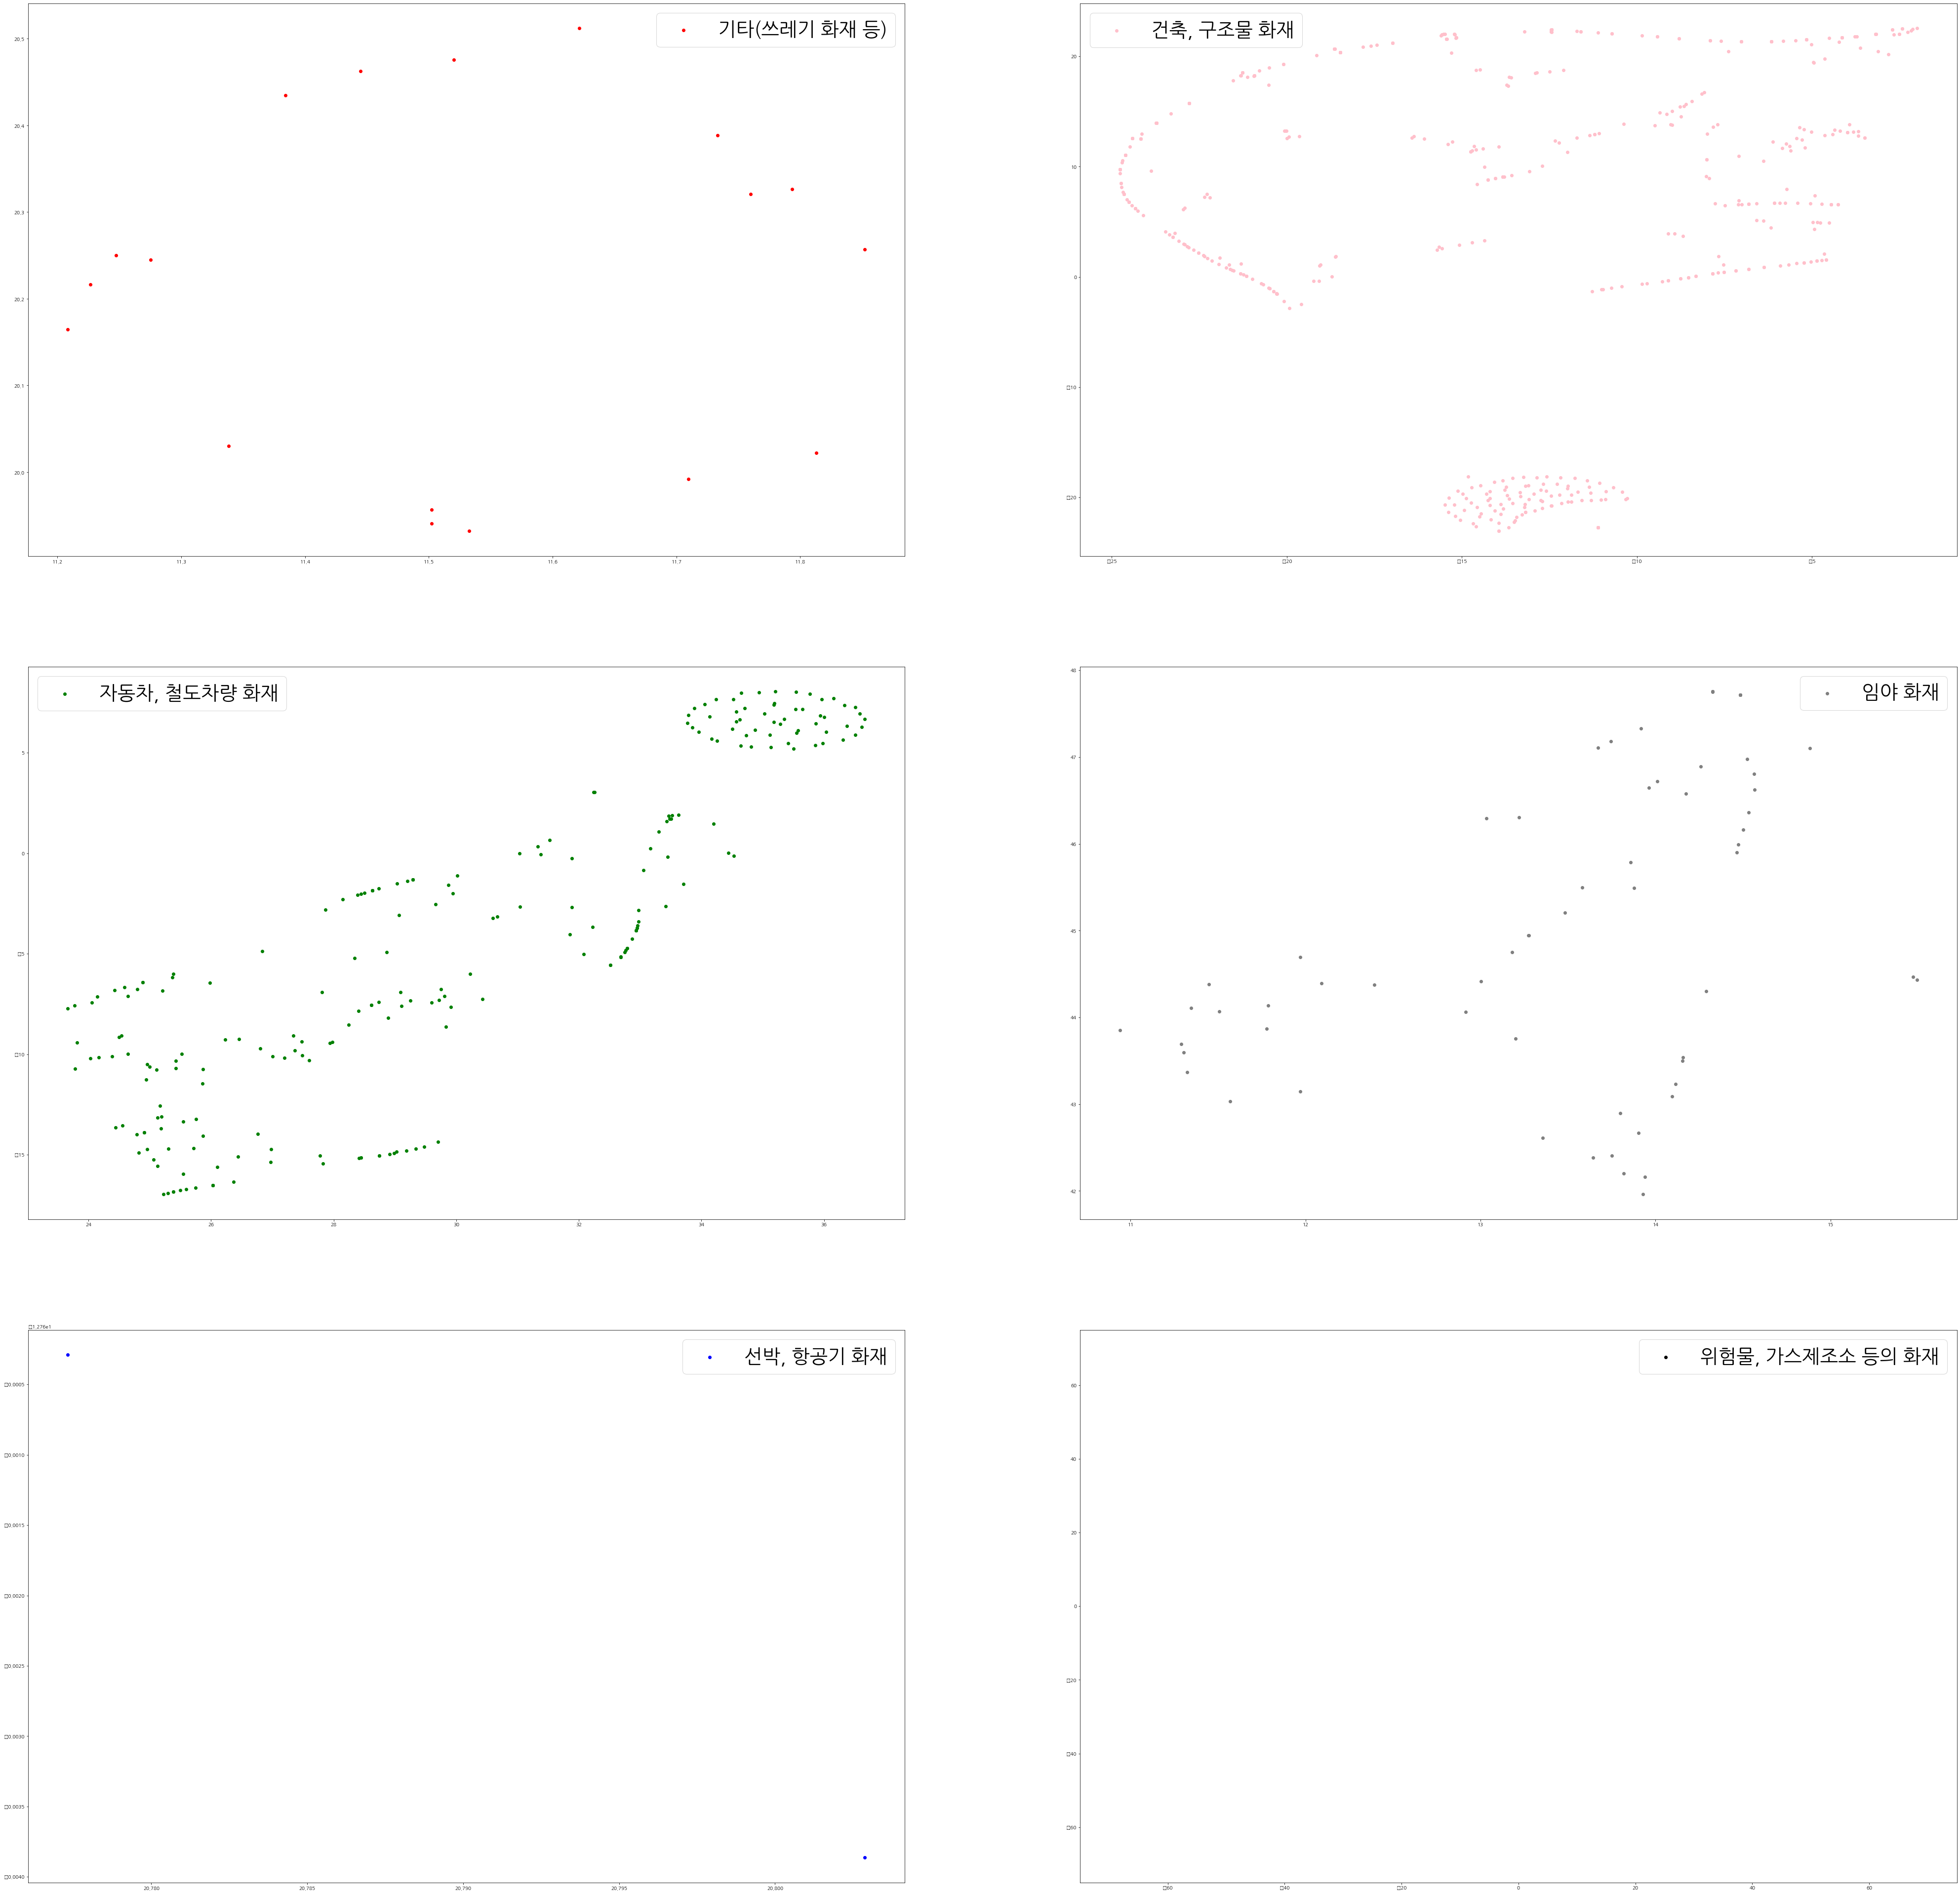

In [47]:
# topic을 6개씩 묶어서 시각화
my_dict = {'v1':digits_tsne[:,0], 'v2':digits_tsne[:,1], 'label':concat_df['label']}
digits_df = pd.DataFrame(my_dict)
x= 0
y= 0
fig, ax = plt.subplots(nrows=3, ncols=2)
plt.rcParams["figure.figsize"] = (70,70)
for j in range(6):
        
    df_1 = digits_df[digits_df['label'] == j]
        
    ax[x][y].scatter(df_1['v1'], df_1['v2'], # x, y , 그룹

             c=colors[j],
            label=topic_vocab[j], # 색상

            ) # font
    plt.xlim(-75, 75) # 최소, 최대

    plt.ylim(-75, 75) # 최소, 최대
    ax[x][y].legend(fontsize = 39)
    if y == 1:
        x +=1
        y = 0
    else:
        y += 1

plt.savefig('fig2.png', dpi=400)
#plt.show() # 그래프 출력 